In [2]:
from importlib import reload

import numpy as np
import scipy as sc
import pandas as pd
from sklearn.decomposition import PCA

import torch
print(torch.cuda.is_available())

import pprint
import editdistance

import utils
import tdre
import shifts
import viennarna_shifts as vshifts

import flexs
import flexs.utils.sequence_utils as s_utils

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

True


2023-11-10 21:28:30.283579: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-10 21:28:30.331471: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-10 21:28:30.331509: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-10 21:28:30.331541: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-10 21:28:30.340797: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: A

# manually inspect length-50 RNA binding landscapes

In [67]:
# RNA binding landscape names: L[length]_RNA[1, 2, 3, 4 binding target][+ ]
reload(vshifts)
n_train = 1000
explorer_kwarg_name2vals = {'threshold': [0.3, 0.2, 0.1, 0.05]}
landscape_name = 'L50_RNA2'
seed_idx = 1

model_class = flexs.baselines.models.LinearRegression
explorer_class = flexs.baselines.explorers.Adalead
flexsshift = vshifts.FLEXSShift(landscape_name)
trainseqs_n, ytrain_n, predtrain_n, calseqs_n, ycal_n, testseqs_list = flexsshift.get_data(
    n_train,
    model_class,
    explorer_class,
    explorer_kwarg_name2vals,
    seed_idx=seed_idx,
    avg_n_mut=2,
    save_fname_prefix=None
)
predcal_n =  flexsshift.explorer.model.get_fitness(calseqs_n)
yseed = flexsshift.landscape.get_fitness([flexsshift.explorer.starting_sequence])[0]

Normalizing by sequence length 50


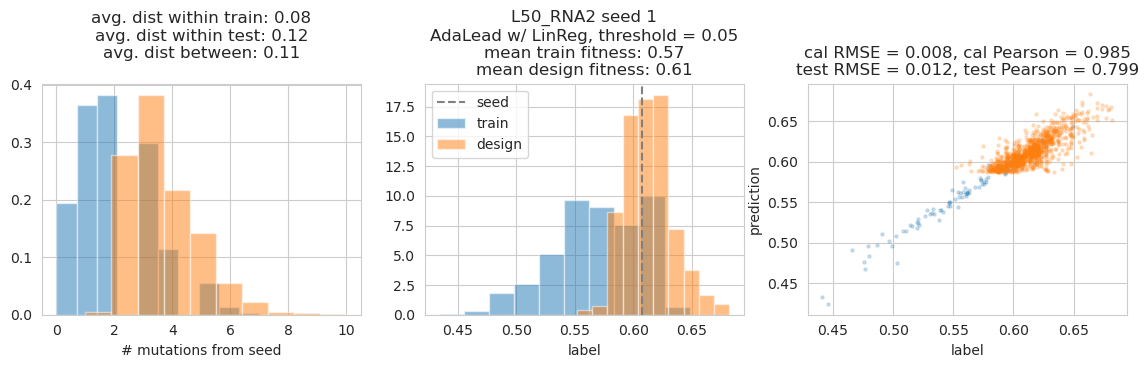

In [72]:
threshold = 0.05
thresh_idx = explorer_kwarg_name2vals['threshold'].index(threshold)
testseqs_n, ytest_n, predtest_n = testseqs_list[thresh_idx]

# mutations away from seed in training and test sequencess
nmuttrain_n = np.array([editdistance.eval(flexsshift.problem['starts'][seed_idx], s) for s in trainseqs_n])
nmuttest_n = np.array([editdistance.eval(flexsshift.problem['starts'][seed_idx], s) for s in testseqs_n])
disttrain, disttest, distbetween = utils.pairwise_distances(trainseqs_n, testseqs_n, n_pairs=10000)

plt.figure(figsize=(14, 3));
plt.subplot(131)
plt.hist(nmuttrain_n, density=True, alpha=0.5);
plt.hist(nmuttest_n, density=True, alpha=0.5);
plt.xlabel('# mutations from seed');
plt.title('avg. dist within train: {:.2f}\navg. dist within test: {:.2f}\navg. dist between: {:.2f}\n'.format(
    np.mean(disttrain), np.mean(disttest), np.mean(distbetween)
))

plt.subplot(132)
plt.hist(ytrain_n, alpha=0.5, density=True);
plt.hist(ytest_n, alpha=0.5, density=True);
plt.axvline(yseed, linestyle='--', color='gray')
plt.title('{} seed {}\nAdaLead w/ LinReg, threshold = {}\nmean train fitness: {:.2}\nmean design fitness: {:.2f}'.format(
    landscape_name, seed_idx, threshold, np.mean(ytrain_n), np.mean(ytest_n)
))
plt.legend(['seed', 'train', 'design', ]);
plt.xlabel('label');

plt.subplot(133)
calrmse = np.sqrt(np.mean(np.square(ycal_n - predcal_n)))
calr, _ = sc.stats.pearsonr(ycal_n, predcal_n)
testrmse = np.sqrt(np.mean(np.square(ytest_n - predtest_n)))
testr, _ = sc.stats.pearsonr(ytest_n, predtest_n)
plt.scatter(ycal_n, predcal_n, alpha=0.2, s=5);
plt.scatter(ytest_n, predtest_n, alpha=0.2, s=5);
plt.xlabel('label');
plt.ylabel('prediction');
plt.title('cal RMSE = {:.3f}, cal Pearson = {:.3f}\ntest RMSE = {:.3f}, test Pearson = {:.3f}'.format(
    calrmse, calr, testrmse, testr
));

In [81]:
reload(vshifts)
save_fname_dir = '110923'
explorer_kwarg_name2vals = {'threshold': [0.4, 0.3, 0.2, 0.1, 0.05]}
model_class = flexs.baselines.models.LinearRegression
explorer_class = flexs.baselines.explorers.Adalead

vshifts.generate_rna_data(
    model_class, explorer_class, explorer_kwarg_name2vals, save_fname_dir
)

Generating data from the following landscapes:
['L50_RNA1', 'L50_RNA2', 'L50_RNA3', 'L50_RNA4']
with the following amounts of training data:
[1000, 10000]
Saved training, calibration, and design data to 110923/L50_RNA1-seed1-n1000-threshold0.4.npz
Saved training, calibration, and design data to 110923/L50_RNA1-seed1-n1000-threshold0.3.npz
Saved training, calibration, and design data to 110923/L50_RNA1-seed1-n1000-threshold0.2.npz
Saved training, calibration, and design data to 110923/L50_RNA1-seed1-n1000-threshold0.1.npz
Saved training, calibration, and design data to 110923/L50_RNA1-seed1-n1000-threshold0.05.npz
Generated and saved data for L50_RNA1, n = 1000, seed 1 (56 s).
Saved training, calibration, and design data to 110923/L50_RNA1-seed2-n1000-threshold0.4.npz
Saved training, calibration, and design data to 110923/L50_RNA1-seed2-n1000-threshold0.3.npz
Saved training, calibration, and design data to 110923/L50_RNA1-seed2-n1000-threshold0.2.npz
Saved training, calibration, and des

Saved training, calibration, and design data to 110923/L50_RNA2-seed1-n10000-threshold0.3.npz
Saved training, calibration, and design data to 110923/L50_RNA2-seed1-n10000-threshold0.2.npz
Saved training, calibration, and design data to 110923/L50_RNA2-seed1-n10000-threshold0.1.npz
Saved training, calibration, and design data to 110923/L50_RNA2-seed1-n10000-threshold0.05.npz
Generated and saved data for L50_RNA2, n = 10000, seed 1 (579 s).
Saved training, calibration, and design data to 110923/L50_RNA2-seed2-n10000-threshold0.4.npz
Saved training, calibration, and design data to 110923/L50_RNA2-seed2-n10000-threshold0.3.npz
Saved training, calibration, and design data to 110923/L50_RNA2-seed2-n10000-threshold0.2.npz
Saved training, calibration, and design data to 110923/L50_RNA2-seed2-n10000-threshold0.1.npz
Saved training, calibration, and design data to 110923/L50_RNA2-seed2-n10000-threshold0.05.npz
Generated and saved data for L50_RNA2, n = 10000, seed 2 (1220 s).
Saved training, cal

Saved training, calibration, and design data to 110923/L50_RNA4-seed1-n1000-threshold0.1.npz
Saved training, calibration, and design data to 110923/L50_RNA4-seed1-n1000-threshold0.05.npz
Generated and saved data for L50_RNA4, n = 1000, seed 1 (51 s).
Saved training, calibration, and design data to 110923/L50_RNA4-seed2-n1000-threshold0.4.npz
Saved training, calibration, and design data to 110923/L50_RNA4-seed2-n1000-threshold0.3.npz
Saved training, calibration, and design data to 110923/L50_RNA4-seed2-n1000-threshold0.2.npz
Saved training, calibration, and design data to 110923/L50_RNA4-seed2-n1000-threshold0.1.npz
Saved training, calibration, and design data to 110923/L50_RNA4-seed2-n1000-threshold0.05.npz
Generated and saved data for L50_RNA4, n = 1000, seed 2 (103 s).
Saved training, calibration, and design data to 110923/L50_RNA4-seed3-n1000-threshold0.4.npz
Saved training, calibration, and design data to 110923/L50_RNA4-seed3-n1000-threshold0.3.npz
Saved training, calibration, and

# try TDRE on length-14 RNA binding landscapes

In [2]:
# TODO: install/move FLEXS
reload(vshifts)
n_train = 10000
explorer_kwarg_name2vals = {'threshold': [0.3, 0.2, 0.1]}
landscape_name = 'L14_RNA1'
save_fname_prefix = '{}-linreg-adalead'.format(landscape_name)

model_class = flexs.baselines.models.LinearRegression
explorer_class = flexs.baselines.explorers.Adalead
flexsshift = vshifts.FLEXSShift(landscape_name)
trainseqs_n, ytrain_n, calseqs_n, ycal_n, testseqs_list = flexsshift.get_data(
    n_train,
    model_class,
    explorer_class,
    explorer_kwarg_name2vals,
    seed_idx=1,
    avg_n_mut=2,
    save_fname_prefix=save_fname_prefix
)
print(ytrain_n.size, ycal_n.size)

Saved training, calibration, and design data to L14_RNA1-linreg-adalead-threshold0.3.npz
Saved training, calibration, and design data to L14_RNA1-linreg-adalead-threshold0.2.npz
Saved training, calibration, and design data to L14_RNA1-linreg-adalead-threshold0.1.npz
10000 1000


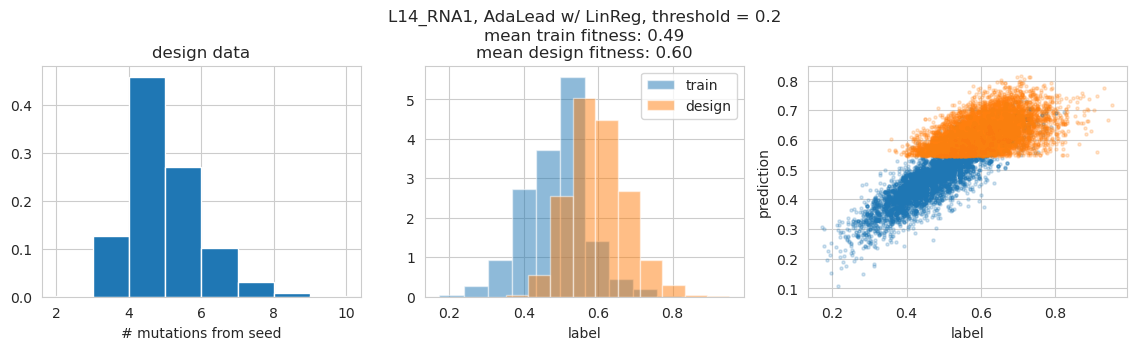

In [21]:
thresh = 0.2  # plot to see individual thresholds
thresh_idx = 1
testseqs_n, ytest_n, predtest_n = testseqs_list[thresh_idx]
nmut_n = np.array([editdistance.eval(flexsshift.problem['starts'][1], s) for s in testseqs_n])
predtrain_n =  flexsshift.explorer.model.get_fitness(trainseqs_n)

plt.figure(figsize=(14, 3));
plt.subplot(131)
plt.hist(nmut_n, density=True, bins=8);
plt.xlabel('# mutations from seed');
plt.title('design data');

plt.subplot(132)
plt.hist(ytrain_n, alpha=0.5, density=True);
plt.hist(ytest_n, alpha=0.5, density=True);
plt.title('{}, AdaLead w/ LinReg, threshold = {}\nmean train fitness: {:.2}\nmean design fitness: {:.2f}'.format(
    landscape_name, thresh, np.mean(ytrain_n), np.mean(ytest_n)
))
plt.legend(['train', 'design']);
plt.xlabel('label');

plt.subplot(133)
plt.scatter(ytrain_n, predtrain_n, alpha=0.2, s=5);
plt.scatter(ytest_n, predtest_n, alpha=0.2, s=5);
plt.xlabel('label');
plt.ylabel('prediction');

In [2]:
# try single bridge for one threshold
landscape_name = 'L14_RNA1'
save_fname_prefix = '{}-linreg-adalead'.format(landscape_name)
threshold = 0.3

dload = np.load('{}-threshold{}.npz'.format(save_fname_prefix, threshold))
trainseqs_n = dload['trainseqs_n']
ytrain_n = dload['ytrain_n']
calseqs_n = dload['calseqs_n']
ycal_n = dload['ycal_n']
testseqs_n = dload['testseqs_n']
ytest_n = dload['ytest_n']
predtest_n = dload['predtest_n']
print(ytrain_n.size, ycal_n.size, ytest_n.size)

d = 14 * 4
m = 1
n_hidden = 16
device = torch.device('cuda')
dtype = torch.float
config = {
    'waymark_type': 'mixed_dimensions',
    'val_frac': 0.1,
    'n_steps': 5000,
    'lr': 1e-3,
}

Xcal_nxd = np.array([s_utils.string_to_one_hot(seq, s_utils.RNAA).flatten() for seq in calseqs_n])
Xm_nxd = np.array([s_utils.string_to_one_hot(seq, s_utils.RNAA).flatten() for seq in trainseqs_n])
X0_nxd = np.array([s_utils.string_to_one_hot(seq, s_utils.RNAA).flatten() for seq in testseqs_n])

model = tdre.UnsharedTelescopingLogDensityRatioEstimator(
#     lambda x: tdre.FeedForward(x, n_hidden=n_hidden), d, n_ratio=m,
    tdre.Quadratic, d, n_ratio=m,
    device=device, dtype=dtype
)

train_dfs = model.fit(X0_nxd, Xm_nxd, config)
classical = model.forecast_meany(Xcal_nxd, ycal_n, use_logsumexp=True)
imputed = np.mean(predtest_n)
truemean = np.mean(ytest_n)
print(truemean, classical, imputed)

10000 1000 10000
Generated 1 waymarks.


100%|████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:10<00:00, 462.08it/s]

Done fitting bridge 1 / 1 (12 s).
0.5728626218906478 0.5014913365170242 0.58811181640625


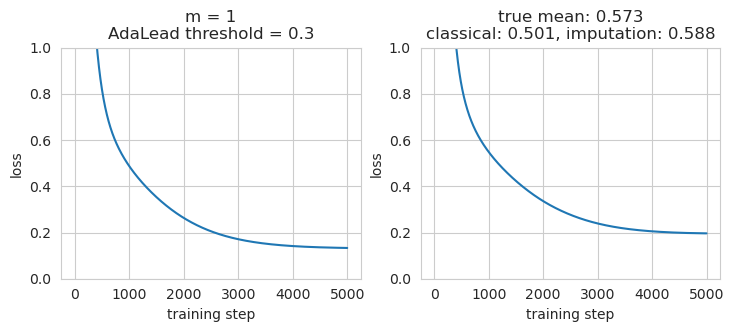

In [3]:
m_to_plot = 1

plt.figure(figsize=(8.5, 3))
plt.subplot(121)
for i in range(m_to_plot):
    plt.plot(train_dfs[i]['train_loss']);
plt.xlabel('training step');
plt.ylabel('loss');
plt.title('m = {}\nAdaLead threshold = {}'.format(m, threshold));
plt.ylim([0, 1]);

plt.subplot(122)
for i in range(m_to_plot):
    plt.plot(train_dfs[i]['val_loss']);
plt.xlabel('training step');
plt.ylabel('loss');
plt.title('true mean: {:.3f}\nclassical: {:.3f}, imputation: {:.3f}'.format(
    truemean, classical, imputed
));
plt.ylim([0, 1]);

In [ ]:
# load up different thresholds as waymarks 
reload(tdre)
landscape_name = 'L14_RNA1'
save_fname_prefix = '{}-linreg-adalead'.format(landscape_name)
thresholds = [0.3]
m = len(thresholds) + 1

dload = np.load('{}-threshold0.1.npz'.format(save_fname_prefix))
testseqs_n = dload['testseqs_n']
ytest_n = dload['ytest_n']
print(np.mean(ytest_n))
X0_nxd = np.array([s_utils.string_to_one_hot(seq, s_utils.RNAA).flatten() for seq in testseqs_n])
X_m1xnxd = np.zeros([m + 1, X0_nxd.shape[0], X0_nxd.shape[1]])
X_m1xnxd[0] = X0_nxd
for i in range(m + 1):
    print(np.linalg.norm(X_m1xnxd[i]))

for t, threshold in enumerate(thresholds):
    dload = np.load('{}-threshold{}.npz'.format(save_fname_prefix, threshold))
    testseqs_n = dload['testseqs_n']
    ytest_n = dload['ytest_n']
    print(np.mean(ytest_n))
    predtest_n = dload['predtest_n']
    Xk_nxd = np.array([s_utils.string_to_one_hot(seq, s_utils.RNAA).flatten() for seq in testseqs_n])
    X_m1xnxd[t + 1] = Xk_nxd
    for i in range(m + 1):
        print(np.linalg.norm(X_m1xnxd[i]))
    
dload = np.load('{}-threshold0.3.npz'.format(save_fname_prefix))
trainseqs_n = dload['trainseqs_n']
ytrain_n = dload['ytrain_n']

print(np.mean(ytrain_n))
Xm_nxd = np.array([s_utils.string_to_one_hot(seq, s_utils.RNAA).flatten() for seq in trainseqs_n])
X_m1xnxd[-1] = Xm_nxd
for i in range(m + 1):
    print(np.linalg.norm(X_m1xnxd[i]))

In [ ]:
# provide waymarks X_m1xnxd from different thresholds
d = 14 * 4
m = X_m1xnxd.shape[0] - 1
n_hidden = 16
device = torch.device('cuda')
dtype = torch.float
config = {
    'waymark_type': 'mixed_dimensions',
    'val_frac': 0.1,
    'n_steps': 5000,
    'lr': 1e-3,
}

model = tdre.UnsharedTelescopingLogDensityRatioEstimator(
#     lambda x: tdre.FeedForward(x, n_hidden=n_hidden), d, n_ratio=m,
    tdre.Quadratic, d, n_ratio=m,
    device=device, dtype=dtype
)

train_dfs = model.fit(config, X_m1xnxd=X_m1xnxd)
classical = model.forecast_meany(Xm_nxd, ytrain_n, use_logsumexp=True)



dload = np.load('{}-threshold0.1.npz'.format(save_fname_prefix))
ytest_n = dload['ytest_n']
predtest_n = dload['predtest_n']

imputed = np.mean(predtest_n)
truemean = np.mean(ytest_n)
print(truemean, classical, imputed)

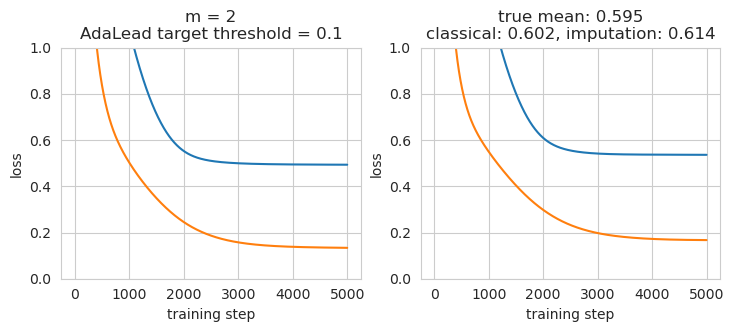

In [11]:
m_to_plot = 2

plt.figure(figsize=(8.5, 3))
plt.subplot(121)
for i in range(m_to_plot):
    plt.plot(train_dfs[i]['train_loss']);
plt.xlabel('training step');
plt.ylabel('loss'); 
plt.title('m = {}\nAdaLead target threshold = {}'.format(m, 0.1));
plt.ylim([0, 1]);

plt.subplot(122)
for i in range(m_to_plot):
    plt.plot(train_dfs[i]['val_loss']);
plt.xlabel('training step');
plt.ylabel('loss');
plt.title('true mean: {:.3f}\nclassical: {:.3f}, imputation: {:.3f}'.format(
    truemean, classical, imputed
));
plt.ylim([0, 1]);

In [14]:
# compare to single bridge
d = 14 * 4
m = 1
n_hidden = 16
device = torch.device('cuda')
dtype = torch.float
config = {
    'waymark_type': 'mixed_dimensions',
    'val_frac': 0.1,
    'n_steps': 5000,
    'lr': 1e-3,
}

dload = np.load('{}-threshold0.1.npz'.format(save_fname_prefix))
trainseqs_n = dload['trainseqs_n']
ytrain_n = dload['ytrain_n']
print(np.mean(ytrain_n))
testseqs_n = dload['testseqs_n']
ytest_n = dload['ytest_n']
predtest_n = dload['predtest_n']
print(np.mean(ytest_n))
X0_nxd = np.array([s_utils.string_to_one_hot(seq, s_utils.RNAA).flatten() for seq in testseqs_n])
Xm_nxd = np.array([s_utils.string_to_one_hot(seq, s_utils.RNAA).flatten() for seq in trainseqs_n])

model = tdre.UnsharedTelescopingLogDensityRatioEstimator(
#     lambda x: tdre.FeedForward(x, n_hidden=n_hidden), d, n_ratio=m,
    tdre.Quadratic, d, n_ratio=m,
    device=device, dtype=dtype
)

train_dfs = model.fit(config, X0_nxp=X0_nxd, Xm_nxp=Xm_nxd)
classical = model.forecast_meany(Xm_nxd, ytrain_n, use_logsumexp=True)
imputed = np.mean(predtest_n)
truemean = np.mean(ytest_n)
print(truemean, classical, imputed)

0.49246304820757086
0.5952103449599836
Generating waymarks.
Generated 1 waymarks.


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:10<00:00, 458.83it/s]

Done fitting bridge 1 / 1 (10 s).
0.5952103449599836 0.5590050446433312 0.61435244140625


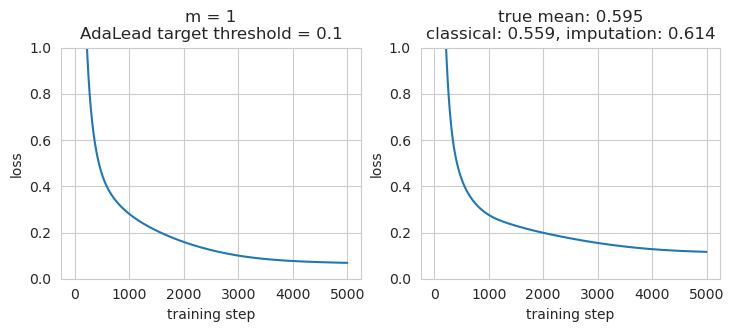

In [16]:
m_to_plot = 1

plt.figure(figsize=(8.5, 3))
plt.subplot(121)
for i in range(m_to_plot):
    plt.plot(train_dfs[i]['train_loss']);
plt.xlabel('training step');
plt.ylabel('loss'); 
plt.title('m = {}\nAdaLead target threshold = {}'.format(m, 0.1));
plt.ylim([0, 1]);

plt.subplot(122)
for i in range(m_to_plot):
    plt.plot(train_dfs[i]['val_loss']);
plt.xlabel('training step');
plt.ylabel('loss');
plt.title('true mean: {:.3f}\nclassical: {:.3f}, imputation: {:.3f}'.format(
    truemean, classical, imputed
));
plt.ylim([0, 1]);

# try unshared bridges on length-50 RNA binding landscapes

Problem has sequence length 50
Loading waymarks in the following order for k = 0, 1, ..., m where k = 0 is the target design distribution.
[0.05, 0.1, 0.2, 0.3]


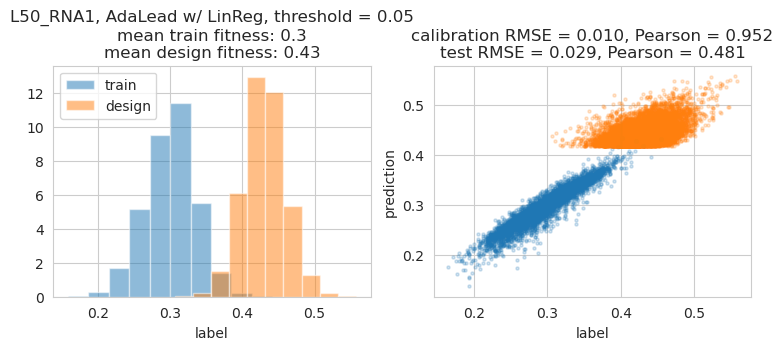

In [87]:
reload(vshifts)
landscape_name = 'L50_RNA1'
seed_idx = 3
n = 10000
thresholds = [0.05, 0.1, 0.2, 0.3]
explorer_kwarg_name2vals = {'threshold': thresholds}
save_fname_dir = '110923/'

X_m1xnxd, y_m1xn, pred_mxn, Xcal_mxnxd, ycal_mxn, predcal_mxn = vshifts.load_rna_data(
    landscape_name,
    seed_idx,
    n,
    explorer_kwarg_name2vals,
    save_fname_dir
)

plt.figure(figsize=(9, 3));
plt.subplot(121)
ytrain_n = y_m1xn[-1]
ytest_n = y_m1xn[0]
plt.hist(ytrain_n, alpha=0.5, density=True, label='train');
plt.hist(ytest_n, alpha=0.5, density=True, label='design');
plt.title('{}, AdaLead w/ LinReg, threshold = {}\nmean train fitness: {:.2}\nmean design fitness: {:.2f}'.format(
    landscape_name, thresholds[0], np.mean(ytrain_n), np.mean(ytest_n)
))
plt.legend();
plt.xlabel('label');

plt.subplot(122)

ycal_n = ycal_mxn[-1]
predcal_n = predcal_mxn[-1]
predtest_n = pred_mxn[0]
calrmse = np.sqrt(np.mean(np.square(ycal_n - predcal_n)))
calr, _ = sc.stats.pearsonr(ycal_n, predcal_n)
testrmse = np.sqrt(np.mean(np.square(ytest_n - predtest_n)))
testr, _ = sc.stats.pearsonr(ytest_n, predtest_n)
plt.scatter(ycal_n, predcal_n, alpha=0.2, s=5);
plt.scatter(ytest_n, predtest_n, alpha=0.2, s=5);
plt.xlabel('label');
plt.ylabel('prediction');
plt.title('calibration RMSE = {:.3f}, Pearson = {:.3f}\ntest RMSE = {:.3f}, Pearson = {:.3f}'.format(
    calrmse, calr, testrmse, testr
));


In [88]:
# provide waymarks X_m1xnxd from different thresholds
reload(tdre)
d = 50 * 4
m = X_m1xnxd.shape[0] - 1
n_hidden = 12
device = torch.device('cuda')
dtype = torch.float
config = {
    'waymark_type': 'mixed_dimensions',
    'val_frac': 0.1,
    'n_steps': 5000,
    'lr': 1e-3,
}

model = tdre.UnsharedTelescopingLogDensityRatioEstimator(
    lambda x: tdre.FeedForward(x, n_hidden=n_hidden), d, n_ratio=m,
    # tdre.Quadratic, d, n_ratio=m,
    device=device, dtype=dtype
)

train_dfs = model.fit(config, X_m1xnxd=X_m1xnxd)

true_mean = np.mean(ytest_n)
classical_tr = model.forecast_meany(X_m1xnxd[-1], y_m1xn[-1], use_logsumexp=True)
classical = model.forecast_meany(Xcal_mxnxd[-1], ycal_mxn[-1], use_logsumexp=True)
imputed = np.mean(predtest_n)

truemean_all = np.array([np.mean(y_n) for y_n in y_m1xn[: -1]])
classical_all = model.forecast_meany_per_bridge(Xcal_mxnxd[-1], ycal_mxn[-1])
imputed_all = np.array([np.mean(pred_n) for pred_n in pred_mxn])

print(true_mean, classical, classical_tr, imputed)
print(truemean_all)
print(classical_all)
print(imputed_all)

4 waymarks provided


100%|██████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:12<00:00, 392.96it/s]


Done fitting bridge 1 / 4 (12 s).


100%|██████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:12<00:00, 409.89it/s]


Done fitting bridge 2 / 4 (24 s).


100%|██████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:12<00:00, 412.60it/s]


Done fitting bridge 3 / 4 (37 s).


100%|██████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:12<00:00, 384.94it/s]

Done fitting bridge 4 / 4 (50 s).
0.4305132541939377 0.45440986622951673 0.4206075873367985 0.44282138671875
[0.43051325 0.41796062 0.38667312 0.36103306]
[0.45440987 0.39617863 0.39172076 0.36679878]
[0.44282139 0.4237874  0.3932063  0.36846719]


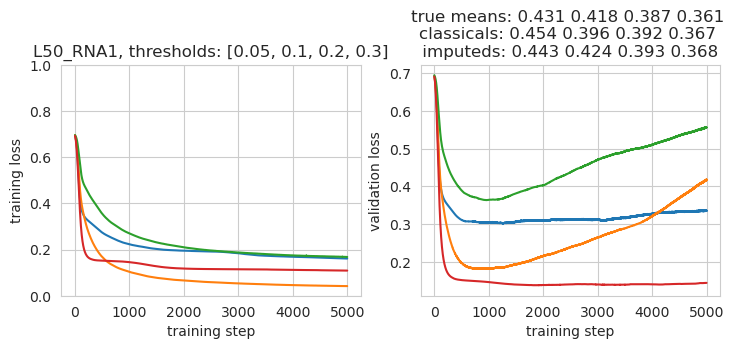

In [90]:
m_to_plot = 4

plt.figure(figsize=(8.5, 3))
plt.subplot(121)
for i in range(m_to_plot):
    plt.plot(train_dfs[i]['train_loss']);
plt.xlabel('training step');
plt.ylabel('training loss'); 
plt.title('{}, thresholds: {}'.format(landscape_name, thresholds));
plt.ylim([0, 1]);

plt.subplot(122)
for i in range(m_to_plot):
    plt.plot(train_dfs[i]['val_loss']);
plt.xlabel('training step');
plt.ylabel('validation loss');
fstr = ''.join(m * ['{:.3f} '])
format_str = 'true means: {}\nclassicals: {}\n imputeds: {}'.format(fstr, fstr, fstr)
values = np.hstack([truemean_all, classical_all, imputed_all])
plt.title(format_str.format(*values));
# plt.ylim([0, 2]);